# No 1: Analisis Klasifikasi Berita (Berita.csv)

## Import Library
Menggunakan library umum untuk pemrosesan data dan machine learning.

In [1]:
import pandas as pd
import numpy as np
import re # Untuk regular expressions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Tambahkan jika ingin menggunakan NLTK untuk preprocessing
# nltk.download('punkt')
# nltk.download('stopwords')

# Untuk menampilkan output lebih rapi
import warnings
warnings.filterwarnings('ignore')

## Load Data



In [5]:
# Load data dari file CSV
# Menggunakan google.colab.files untuk menampilkan pop-up upload file
from google.colab import files
import io

uploaded = files.upload()

# Asumsikan hanya satu file yang diupload
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  # Karena file memiliki header, kita bisa membacanya langsung tanpa header=None
  df_berita = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))


# Beri nama kolom berdasarkan struktur yang dilihat sebelumnya
# Kolom 0: No, Kolom 1: judul, Kolom 2: berita, Kolom 3: tanggal, Kolom 4: kategori, Kolom 5: link
# Jika Anda ingin mengganti nama kolom yang sudah ada, gunakan rename
df_berita.columns = ['No', 'judul', 'isi_berita', 'tanggal', 'kategori', 'url']


print("Ukuran Data:", df_berita.shape)
print("\nTampilan Awal Data:")
print(df_berita.head())

print("\nJumlah data per kategori:")
print(df_berita['kategori'].value_counts())

Saving Berita.csv to Berita (1).csv
User uploaded file "Berita (1).csv" with length 3941868 bytes
Ukuran Data: (1500, 6)

Tampilan Awal Data:
   No                                              judul  \
0   1  Airlangga Harap Kenaikan UMP Tingkatkan Daya B...   
1   2  PT SIER Beri Penghargaan untuk 50 Tenant Terba...   
2   3  Prabowo Bakal Bentuk Kementerian Penerimaan Ne...   
3   4  Sinergi Kemenag & BPJS Ketenagakerjaan Lindung...   
4   5  Pemerintah Segera Bentuk Satgas PHK Usai Tetap...   

                                          isi_berita  \
0  Menteri Koordinator (Menko) Bidang Perekonomia...   
1  Dalam rangka memeriahkan hari jadi ke-50, PT S...   
2  Wacana Presiden Prabowo Subianto akan membentu...   
3  BPJS Ketenagakerjaan dan Kementerian Agama (Ke...   
4  Pemerintah akan segera membentuk Satuan Tugas ...   

                         tanggal kategori  \
0  Minggu, 01 Des 2024 23:40 WIB  Ekonomi   
1  Minggu, 01 Des 2024 20:45 WIB  Ekonomi   
2  Minggu, 01 Des 2024 19

## Pra-pemrosesan Data
Membersihkan dan menyiapkan teks untuk analisis. Ini termasuk menggabungkan kolom-kolom teks jika diperlukan, membersihkan karakter aneh, menghilangkan angka, spasi berlebih, mengubah teks menjadi huruf kecil, melakukan tokenisasi, dan menghilangkan stop words. Langkah ini memastikan tidak ada nilai kosong yang mengganggu dan teks siap untuk tahap selanjutnya.

In [11]:
# Fungsi sederhana untuk membersihkan teks
def clean_text(text):
    if pd.isna(text):
        return ""
    # Hilangkan karakter aneh dan simbol yang tidak perlu
    text = re.sub(r'[^\w\s]', ' ', str(text))
    # Hilangkan angka
    text = re.sub(r'\d+', '', text)
    # Hilangkan spasi berlebih
    text = ' '.join(text.split())
    # Konversi ke huruf kecil
    text = text.lower()
    return text

# Terapkan fungsi ke kolom isi_berita
df_berita['isi_berita_clean'] = df_berita['isi_berita'].apply(clean_text)

# Hilangkan baris dengan isi_berita_clean kosong
df_berita = df_berita[df_berita['isi_berita_clean'].str.len() > 0]

# Unduh resource NLTK jika belum ada (tetap dibutuhkan untuk stop words)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Tokenisasi sederhana (split by space) dan hilangkan stop words
stop_words = set(stopwords.words('indonesian')) # Gunakan stop words Bahasa Indonesia
def tokenize_and_filter(text):
    tokens = text.split() # Simple split by space
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

df_berita['isi_berita_processed'] = df_berita['isi_berita_clean'].apply(tokenize_and_filter)


# Cek ulang ukuran data
print("Ukuran Data Setelah Pra-pemrosesan:", df_berita.shape)

# Cek apakah kategori kosong
print("\nJumlah data per kategori setelah cleaning:")
print(df_berita['kategori'].value_counts())

# Ambil teks bersih dan kategori
X_text = df_berita['isi_berita_processed'] # Gunakan kolom yang sudah diproses
y_category = df_berita['kategori']

print("\nTampilan Awal Data setelah Tokenisasi dan Stop Words Removal:")
print(df_berita[['isi_berita_clean', 'isi_berita_processed']].head())

Ukuran Data Setelah Pra-pemrosesan: (1500, 8)

Jumlah data per kategori setelah cleaning:
kategori
Ekonomi          375
Olahraga         375
Nasional         375
Internasional    375
Name: count, dtype: int64

Tampilan Awal Data setelah Tokenisasi dan Stop Words Removal:
                                    isi_berita_clean  \
0  menteri koordinator menko bidang perekonomian ...   
1  dalam rangka memeriahkan hari jadi ke pt surab...   
2  wacana presiden prabowo subianto akan membentu...   
3  bpjs ketenagakerjaan dan kementerian agama kem...   
4  pemerintah akan segera membentuk satuan tugas ...   

                                isi_berita_processed  
0  menteri koordinator menko bidang perekonomian ...  
1  rangka memeriahkan pt surabaya industrial esta...  
2  wacana presiden prabowo subianto membentuk mem...  
3  bpjs ketenagakerjaan kementerian agama kemenag...  
4  pemerintah membentuk satuan tugas pemutusan hu...  


## Ekstraksi Fitur (TF-IDF)
Mengubah teks menjadi representasi numerik menggunakan TF-IDF.

In [12]:
# Inisialisasi TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english') # Bisa disesuaikan

# Fit dan transform teks
X_tfidf = vectorizer.fit_transform(X_text)

print("Ukuran Matriks TF-IDF:", X_tfidf.shape)

Ukuran Matriks TF-IDF: (1500, 5000)


## Topic Modelling (LDA)
Mencoba menemukan topik-topik utama dalam berita.

In [14]:
# Inisialisasi LDA
n_topics = 5 # Misalnya, ingin menemukan 5 topik
# LatentDirichletAllocation untuk menemukan topik dalam data teks
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)

# Fit LDA ke matriks TF-IDF
lda_model.fit(X_tfidf)

# Fungsi untuk menampilkan kata-kata penting dalam setiap topik
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topik #{topic_idx}: "
        message += " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(message)

# Ambil nama fitur (kata-kata) dari vectorizer
feature_names = vectorizer.get_feature_names_out()

# Tampilkan topik
print(f"\n--- Hasil Topic Modelling (LDA) dengan {n_topics} Topik ---")
display_topics(lda_model, feature_names, 10)


--- Hasil Topic Modelling (LDA) dengan 5 Topik ---
Topik #0: laut pagar tangerang kkp nelayan sertifikat misterius perikanan hgb nusron
Topik #1: persen rp prabowo program kpk ppn jakarta harga makan pemerintah
Topik #2: israel gaza gencatan senjata kebakaran korban trump hamas warga orang
Topik #3: mentah barel minyak sen hasjim brent hmpv texas wti intermediate
Topik #4: timnas indonesia pemain piala gol pelatih menit laga vietnam pertandingan


## Klasifikasi (Naive Bayes dan SVM)
Melatih model klasifikasi menggunakan fitur TF-IDF untuk memprediksi kategori berita (misalnya Nasional, Internasional, Ekonomi, dll., jika labelnya tersedia atau bisa dibuat dari data).

In [15]:
# Bagi data menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_category, test_size=0.2, random_state=42, stratify=y_category)

# --- Naive Bayes ---
print("\n--- Klasifikasi dengan Naive Bayes ---")
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Prediksi
y_pred_nb = nb_model.predict(X_test)

# Evaluasi
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f"Akurasi Naive Bayes: {acc_nb:.4f}")
print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))

# --- SVM ---
print("\n--- Klasifikasi dengan SVM ---")
# SVM bisa memakan waktu lama untuk data besar, gunakan subset jika perlu
# Misalnya, gunakan hanya 1000 data pertama untuk demonstrasi cepat
# X_train_svm, y_train_svm = X_train[:1000], y_train[:1000]
# X_test_svm, y_test_svm = X_test[:500], y_test[:500]

# Untuk demonstrasi penuh, gunakan data train/test asli (bisa lama)
svm_model = SVC(kernel='linear', random_state=42) # Linear kernel umum digunakan untuk teks
svm_model.fit(X_train, y_train)

# Prediksi
y_pred_svm = svm_model.predict(X_test)

# Evaluasi
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"Akurasi SVM: {acc_svm:.4f}")
print("\nClassification Report (SVM):")
print(classification_report(y_test, y_pred_svm))

# Jika ingin melihat confusion matrix untuk salah satu model
print("\nConfusion Matrix (SVM):")
print(confusion_matrix(y_test, y_pred_svm))


--- Klasifikasi dengan Naive Bayes ---
Akurasi Naive Bayes: 0.9400

Classification Report (Naive Bayes):
               precision    recall  f1-score   support

      Ekonomi       0.84      0.97      0.90        75
Internasional       0.99      0.99      0.99        75
     Nasional       0.97      0.80      0.88        75
     Olahraga       0.99      1.00      0.99        75

     accuracy                           0.94       300
    macro avg       0.95      0.94      0.94       300
 weighted avg       0.95      0.94      0.94       300


--- Klasifikasi dengan SVM ---
Akurasi SVM: 0.9533

Classification Report (SVM):
               precision    recall  f1-score   support

      Ekonomi       0.88      0.97      0.92        75
Internasional       1.00      0.97      0.99        75
     Nasional       0.96      0.87      0.91        75
     Olahraga       0.99      1.00      0.99        75

     accuracy                           0.95       300
    macro avg       0.96      0.95   

# No 2: Analisis Clustering Dokumen (spam.csv)

## Import Library
Menggunakan library yang diperlukan untuk clustering.

In [16]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [19]:
# Load data dari file CSV
# Menggunakan google.colab.files untuk menampilkan pop-up upload file
from google.colab import files
import io

uploaded = files.upload()

# Asumsikan hanya satu file yang diupload
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  # Coba berbagai encoding jika utf-8 gagal, misalnya 'latin-1' atau 'ISO-8859-1'
  try:
      # Baca dengan header=0 karena file sepertinya punya header di baris pertama
      df_spam = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), header=0)
  except UnicodeDecodeError:
      print("UTF-8 decoding failed, trying latin-1...")
      # Baca dengan header=0 karena file sepertinya punya header di baris pertama
      df_spam = pd.read_csv(io.StringIO(uploaded[fn].decode('latin-1')), header=0)


# Beri nama kolom untuk kemudahan
# Asumsikan kolom pertama adalah 'label' (sebelumnya 'id') dan kolom kedua adalah 'pesan' (sebelumnya 'Text')
# Kita akan mengganti nama kolom pertama dan kedua
df_spam.columns.values[:2] = ['label', 'pesan']


# Gabungkan kolom-kolom yang tersisa jika ada (untuk jaga-jaga jika struktur berbeda)
# Misalnya, jika ada kolom tambahan setelah 'pesan' yang merupakan bagian dari pesan
# Kita hanya akan menggunakan kolom 'label' dan 'pesan'
df_spam = df_spam[['label', 'pesan']]


print("Ukuran Data:", df_spam.shape)
print("\nTampilan Awal Data (pesan_utuh):")
print(df_spam.head()) # Tampilkan 5 baris pertama

print("\nJumlah data per label:")
print(df_spam['label'].value_counts())

Saving spam.csv to spam (2).csv
User uploaded file "spam (2).csv" with length 507385 bytes
UTF-8 decoding failed, trying latin-1...
Ukuran Data: (5572, 2)

Tampilan Awal Data (pesan_utuh):
   label                                              pesan
0      1  Go until jurong point, crazy.. Available only ...
1      2                      Ok lar... Joking wif u oni...
2      3  Free entry in 2 a wkly comp to win FA Cup fina...
3      4  U dun say so early hor... U c already then say...
4      5  Nah I don't think he goes to usf, he lives aro...

Jumlah data per label:
label
5572    1
1       1
2       1
3       1
5556    1
       ..
9       1
8       1
7       1
6       1
5       1
Name: count, Length: 5572, dtype: int64


## Pra-pemrosesan Data
Kita akan membersihkan teks dan memastikan hanya pesan yang relevan yang diproses.

In [21]:
# Fungsi untuk membersihkan teks pesan
def clean_text_sms(text):
    if pd.isna(text):
        return ""
    # Hilangkan karakter aneh dan simbol yang tidak perlu
    text = re.sub(r'[^\w\s]', ' ', str(text))
    # Hilangkan spasi berlebih
    text = ' '.join(text.split())
    # Konversi ke huruf kecil
    text = text.lower()
    return text

# Terapkan fungsi ke kolom pesan
df_spam['pesan_clean'] = df_spam['pesan'].apply(clean_text_sms)

# Hilangkan baris dengan pesan_clean kosong atau hanya berisi angka (ID)
# Kita bisa menggunakan regex untuk memeriksa apakah teks hanya angka
df_spam = df_spam[~df_spam['pesan_clean'].str.match(r'^\d+$', na=False)] # Hilangkan baris yang hanya berisi angka
df_spam = df_spam[df_spam['pesan_clean'].str.len() > 0] # Hilangkan baris kosong

print("Ukuran Data Setelah Pra-pemrosesan:", df_spam.shape)

# Ambil teks bersih untuk clustering
X_sms_text = df_spam['pesan_clean']

print("\nBeberapa contoh pesan setelah cleaning:")
print(X_sms_text.head(10).values)

Ukuran Data Setelah Pra-pemrosesan: (5569, 3)

Beberapa contoh pesan setelah cleaning:
['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat'
 'ok lar joking wif u oni'
 'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry question std txt rate t c s apply 08452810075over18 s'
 'u dun say so early hor u c already then say'
 'nah i don t think he goes to usf he lives around here though'
 'freemsg hey there darling it s been 3 week s now and no word back i d like some fun you up for it still tb ok xxx std chgs to send å 1 50 to rcv'
 'even my brother is not like to speak with me they treat me like aids patent'
 'as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press 9 to copy your friends callertune'
 'winner as a valued network customer you have been selected to receivea å 900 prize reward to claim call 09061701461 claim co

## Ekstraksi Fitur (TF-IDF)
Mengubah teks pesan menjadi representasi numerik menggunakan TF-IDF.

In [22]:
# Inisialisasi TfidfVectorizer
# Karena ini pesan singkat, kita bisa menyesuaikan parameter
vectorizer_sms = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2)) # ngram_range bisa digunakan untuk mempertimbangkan pasangan kata

# Fit dan transform teks
X_sms_tfidf = vectorizer_sms.fit_transform(X_sms_text)

print("Ukuran Matriks TF-IDF:", X_sms_tfidf.shape)

Ukuran Matriks TF-IDF: (5569, 1000)


## Clustering (K-Means)
Menggunakan algoritma K-Means untuk mengelompokkan pesan.

In [23]:
# Tentukan jumlah cluster (k)
# Ini bisa diiterasi atau dipilih berdasarkan domain knowledge atau metode seperti Elbow Method
k = 5 # Misalnya, ingin menemukan 5 cluster

# Inisialisasi dan fit KMeans
kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init untuk versi sklearn terbaru
kmeans_model.fit(X_sms_tfidf)

# Dapatkan label cluster untuk setiap pesan
cluster_labels = kmeans_model.labels_

# Tambahkan label cluster ke dataframe
df_spam['cluster'] = cluster_labels

print(f"\n--- Hasil Clustering dengan K-Means (k={k}) ---")
print(f"Jumlah pesan per cluster:")
print(df_spam['cluster'].value_counts().sort_index())


--- Hasil Clustering dengan K-Means (k=5) ---
Jumlah pesan per cluster:
cluster
0     287
1    4406
2     254
3     399
4     223
Name: count, dtype: int64


## Evaluasi dan Analisis Cluster
Menghitung Silhouette Score dan melihat contoh pesan dari masing-masing cluster.

In [25]:
# Hitung Silhouette Score
silhouette_avg = silhouette_score(X_sms_tfidf, cluster_labels)
print(f"\nSilhouette Score untuk k={k}: {silhouette_avg:.4f}")

# Lihat contoh pesan dari masing-masing cluster
print("\n--- Contoh Pesan dari Setiap Cluster ---")
for i in range(k):
    print(f"\nCluster {i}:")
    cluster_messages = df_spam[df_spam['cluster'] == i]['pesan'].head(5) # Use 'pesan' column
    for idx, msg in enumerate(cluster_messages):
        print(f"  {idx+1}. {msg}")


Silhouette Score untuk k=5: 0.0225

--- Contoh Pesan dari Setiap Cluster ---

Cluster 0:
  1. England v Macedonia - dont miss the goals/team news. Txt ur national team to 87077 eg ENGLAND to 87077 Try:WALES, SCOTLAND 4txt/Ì¼1.20 POBOXox36504W45WQ 16+
  2. Aft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already?
  3. Today is \song dedicated day..\" Which song will u dedicate for me? Send this to all ur valuable frnds but first rply me..."
  4. Urgent UR awarded a complimentary trip to EuroDisinc Trav, Aco&Entry41 Or å£1000. To claim txt DIS to 87121 18+6*å£1.50(moreFrmMob. ShrAcomOrSglSuplt)10, LS1 3AJ
  5. Ela kano.,il download, come wen ur free..

Cluster 1:
  1. Ok lar... Joking wif u oni...
  2. Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
  3. U dun say so early hor... U c already then say...
  4. Nah I don't think he goes to usf, he lives

## (Opsional) Visualisasi Sederhana
Menggunakan t-SNE untuk mereduce dimensi dan memvisualisasikan cluster (ini bisa memakan waktu untuk data besar).

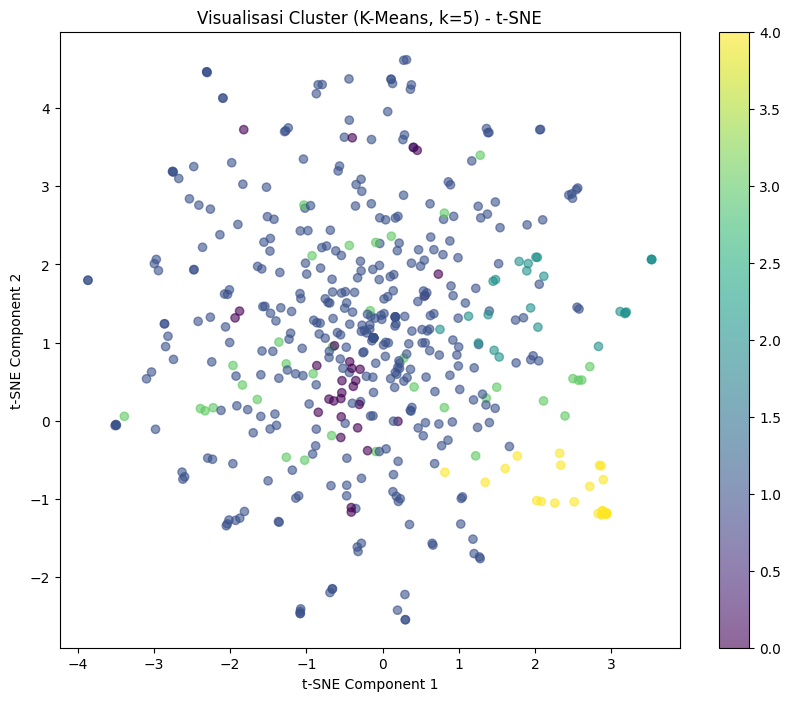

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Ambil subset data untuk visualisasi karena t-SNE bisa lambat
sample_size = 500
if X_sms_tfidf.shape[0] > sample_size:
    indices = np.random.choice(X_sms_tfidf.shape[0], sample_size, replace=False)
    X_subset = X_sms_tfidf[indices]
    labels_subset = cluster_labels[indices]
else:
    X_subset = X_sms_tfidf
    labels_subset = cluster_labels

# Inisialisasi t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, X_subset.shape[0] - 1))

# Transformasi data ke 2D
X_tsne = tsne.fit_transform(X_subset.toarray()) # .toarray() karena X_subset adalah sparse matrix

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_subset, cmap='viridis', alpha=0.6)
plt.title(f'Visualisasi Cluster (K-Means, k={k}) - t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter)
plt.show()